In [53]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
names = open('names.txt', 'r').read().splitlines()

#Dictionary mapping characters to integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [55]:
block_size = 3 #context length
X, Y = [], [] #inputs and labels for NN
for n in names:
    context = [0] * block_size #padding for initial characters
    for ch in n + '.':
        index = stoi[ch]
        X.append(context)
        Y.append(index)
        context = context[1:] + [index] #remove and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [56]:
g = torch.Generator().manual_seed(2147483647)
#Lookup table for embedding
C = torch.randn((27, 2), generator=g) #2 dimensions for all 27 characters
#------------------------
#emb = C[X]
#emb.shape 
#------------------------
#C is a list of 27 vectors of size 2(embedding for each character)
#X is a grid of numbers with no of rows = no of examples and context window size columns
#We need to get embeddings so we need to index into C using X where each number in X tells you which row to pick from C
#So C[X] returns a new grid that’s the same shape as X (32 × 3), but instead of just numbers, each cell now holds a 2-value vector from C
#Hence the shape becomes (32, 3, 2)
#Example: X[13, 2] = 5 (X 13th row, 2nd column) = 5
#C[X][13, 2] = C[5] = [a1, a2]


In [57]:
lre = torch.linspace (-3, 0, 1000) #Linearly create 1000 numbers from -3 to 1
lrs = 10**lre #Space the learning rates exponentially rather than linearly (10^-3 to 10^0)

In [58]:
W1 = torch.randn((6, 100), generator=g) #6 inputs (3 two dimensional embeddings), no of outputs = 100 neurons
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
     p.requires_grad = True

lri = []
lossi = []

for i in range (1000):
    #minibatch: Train on batches
    batchIndexes = torch.randint(0, X.shape[0], (32,)) #32 random rows from X

    #Embedding (see above)
    emb = C[X[batchIndexes]]

    #Concatenate the embedding (concatenate so that each example has its 3 * 2 values in one row)
    #torch.cat(torch.unbind(emb, 1), 1) #unbind along dimension 1 and concatenate to get 32 rows of 6 values each
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #emb.view reshapes the tensor (does not need new memory) into 6 columsn and the -1 means python will infer the number of rows which is emb.shape[0]

    #Forward Pass
    logits = h @ W2 + b2

    #Old loss implementation
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean() #For all 32 examples index the probabilities with Y to get the prob predicted of the actual answer. Then take negative log likelihood
    loss = F.cross_entropy(logits, Y[batchIndexes]) #More efficient (forward and backward passes) and numerically well behaved
    print (loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    lr = lrs[i]
    #lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    #Track learning rate
    lri.append(lre[i])
    lossi.append(loss.item())

21.043460845947266
20.58588981628418
21.376720428466797
15.023594856262207
17.673542022705078
20.37964630126953
21.91461753845215
19.918222427368164
19.310937881469727
17.462303161621094
17.94655418395996
19.606067657470703
18.114269256591797
22.025388717651367
18.87513542175293
19.440793991088867
19.801057815551758
19.103546142578125
18.855710983276367
19.074247360229492
18.770702362060547
17.628629684448242
19.552337646484375
16.492998123168945
16.95872688293457
17.967533111572266
20.823516845703125
19.887847900390625
17.409114837646484
20.105121612548828
16.678064346313477
18.01800537109375
22.051774978637695
18.11026382446289
17.96626853942871
22.133392333984375
17.11195945739746
18.19922637939453
16.570877075195312
21.5631160736084
18.80343246459961
20.049964904785156
19.883522033691406
18.655948638916016
18.135547637939453
19.1203670501709
20.947525024414062
19.32774543762207
18.594236373901367
17.122455596923828
18.010473251342773
15.241738319396973
16.511219024658203
15.7282018

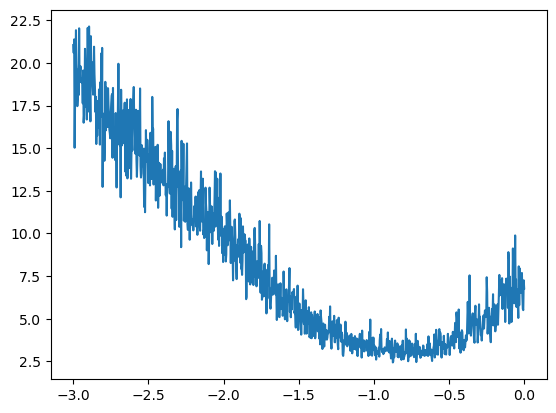

In [59]:
plt.plot(lri, lossi)